In [1]:
# Import necessary libraries
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn



# Initialize CLIP processor and tokenizer
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device:', device)

Current device: cuda


In [3]:
class CaptionDataset(Dataset):
    def __init__(self, dataset, clip_model_name="openai/clip-vit-base-patch32", device=device):
        self.image = dataset['image']
        self.caption_list = dataset['caption']
        
        self.device = device

        self.processor = CLIPProcessor.from_pretrained(clip_model_name)
        self.tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)
        self.clip_model = CLIPModel.from_pretrained(clip_model_name).eval().to(self.device)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        caption_list = self.caption_list[idx]
        
        # ---- Encode image with CLIP ----
        img_tensor = self.processor(images=image, return_tensors="pt").to(self.device)
        #print('IMG TENSOR SHAPE', img_tensor.shape) # channels, height, width
        
        # ---- Tokenize input caption ----
        caption = caption_list[0] # get the first caption in the list
        print('caption len:', len(caption))
        print('caption:', caption)
        tokens = self.tokenizer(caption, padding="max_length", max_length=32, return_tensors="pt", truncation=True)

        input_ids_full = tokens["input_ids"].to(self.device)  # [1, seq_len]
        #print('text_input_ids_full shape:', input_ids_full.shape)
        mask = tokens["attention_mask"].to(self.device) # get the mask out

        with torch.no_grad():
            # Use only embedding layer from CLIP
            text_embeddings = self.clip_model.text_model.embeddings(input_ids_full).squeeze(0).to(self.device)

            # Get the CLIP encoded image embeddings
            patch_embeddings = self.clip_model.vision_model(**img_tensor).last_hidden_state[:, 1:, :].squeeze(0).to(self.device) # shape: [1, num_patches, hidden_dim]
            #print('Patch embeddings shape:', patch_embeddings.shape)           
            
            
        target_ids = input_ids_full.squeeze(0).to(self.device)

        #print('IMG EMBEDDINGS SHAPE', patch_embeddings.shape)
        #print('TEXT EMBEDDINGS SHAPE', text_embeddings.shape)
        #print('TARGET IDS SHAPE', target_ids.shape)
        #print('MASK SHAPE', mask.shape)

        return patch_embeddings, text_embeddings, target_ids, mask
            


# create the image captioning model

⬆️ The code above projects the text and image embeddings into the same shape so now we can send it! 

In [4]:
# Create Masked Self Attention Head
class MaskedAttentionHead(nn.Module):
    def __init__(self, embedding_dim, head_dim):
        super(MaskedAttentionHead, self).__init__()
        self.head_dim = head_dim

        # Linear projections for query, key, value
        self.weight_q = nn.Linear(embedding_dim, head_dim)
        self.weight_k = nn.Linear(embedding_dim, head_dim)
        self.weight_v = nn.Linear(embedding_dim, head_dim)

        self.linear_projection = nn.Linear(head_dim, embedding_dim)

    def forward(self, decoder_sequence, input_sequence_length, padding_mask=None, ):
        # embedded decoder sequence shape: [batch_size, seq_length, embedding_dim]

        #print('Decoder sequence shape:', decoder_sequence.shape)

        # Project to head dimension
        Q = self.weight_q(decoder_sequence)
        K = self.weight_k(decoder_sequence)
        V = self.weight_v(decoder_sequence)

        # Make the mask
        decoder_sequence_length = decoder_sequence.shape[1]
        #mask = torch.triu(torch.ones(decoder_sequence_length, decoder_sequence_length, device=decoder_sequence.device), diagonal=1)
        #print("Causal mask shape:", mask.shape)
        #mask = mask.masked_fill(mask==1, float('-inf'))

        mask = torch.zeros(decoder_sequence_length, decoder_sequence_length, device=decoder_sequence.device)
        
        # Only mask the text portion (after image patches)
        num_image_patches = 49  # CLIP ViT-B/32 has 49 patches
        text_start_idx = num_image_patches
        
        # Create causal mask for text portion only
        text_mask = torch.triu(torch.ones(decoder_sequence_length - text_start_idx, decoder_sequence_length - text_start_idx, 
                                        device=decoder_sequence.device), diagonal=1)
        text_mask = text_mask.masked_fill(text_mask==1, float('-inf'))
        
        # Place the text mask in the bottom-right corner of the full mask
        mask[text_start_idx:, text_start_idx:] = text_mask
        

        # Calculate attention scores (scaled dot product)
        A = torch.einsum('bid,bjd->bij', Q, K)
        A = A / (self.head_dim ** 0.5) 

        A = A + mask

        
        # Apply padding mask if provided
        #if padding_mask is not None:
            #print('Padding mask shape:', padding_mask.shape)
            # Convert padding mask to attention mask
        #    padding_mask = padding_mask.expand(-1, A.size(1), -1)
        #    A = A.masked_fill(padding_mask, float('-inf'))
            
        # Apply softmax
        A = torch.softmax(A, dim=-1)

    
        #  Apply attention weights to values
        H = torch.einsum('bij,bjd->bid', A, V)
        
        # Add projection layer for output to return back to the original embedding dimension
        #output = self.linear_projection(H)

        return H

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads

     
        self.heads = nn.ModuleList(
            [MaskedAttentionHead(embedding_dim, self.head_dim) for _ in range(num_heads)]
            )
        
        # The output of the CrossAttention Head and MaskedAttentionHead still needs to be projected
        # Back to the embedding dimensions of the head_dim x vocab_size
        
        self.output_projection = nn.Linear(num_heads * self.head_dim, embedding_dim)

        

    def forward(self, decoder_sequence, padding_mask=None):
        # decoder_sequence: [batch_size, seq_length, embedding_dim]
        # encoder_output: [batch_size, num_patches, embedding_dim] (only used in cross-attention)
        # mask: [batch_size, seq_length, seq_length] (only used in self-attention)

        # Process each head
        head_outputs = []
        for head in self.heads:
                # For masked self-attention, we only need decoder sequence and mask
                head_output = head(decoder_sequence, padding_mask)
                #print("\nmasked attention head output shape: ", head_output.shape)
                
                head_outputs.append(head_output)

        # Concatenate head outputs
        concat_heads = torch.cat(head_outputs, dim=-1)
        
        # Project back to embedding dimension
        output = self.output_projection(concat_heads)
        #print("Multihead attention output shape: ", output.shape)
        
        return output



In [6]:
class DecoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dimension):
        super(DecoderBlock, self).__init__()
        
        # First layer norm
        self.ln1 = nn.LayerNorm(embedding_dim)
        
        # Masked multi-head attention for decoder sequence self-attention
        self.masked_mha = MultiHeadAttention(embedding_dim, num_heads)
        
        
        # Third layer norm
        self.ln2 = nn.LayerNorm(embedding_dim)
        
        # Feed forward network
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dimension),
            nn.ReLU(),
            nn.Linear(mlp_dimension, embedding_dim)
        )

    def forward(self, decoder_sequence, padding_mask=None):
        # decoder_sequence: the input sequence to decode (e.g., [START, 1, 2, 3])
        # encoder_output: the encoded image from the encoder
        # mask: causal mask to prevent attending to future tokens

        # First masked self-attention block with residual connection
        # This allows decoder sequence to attend to its own past tokens
        # First masked self-attention
        residual = decoder_sequence
        decoder_sequence = self.ln1(decoder_sequence)
        decoder_sequence = self.masked_mha(decoder_sequence, padding_mask)
        decoder_sequence = residual + decoder_sequence

        
        # # FFN block with residual connection
        residual = decoder_sequence
        decoder_sequence = self.ln2(decoder_sequence)
        decoder_sequence = self.ffn(decoder_sequence)
        decoder_sequence = residual + decoder_sequence
        
        return decoder_sequence



In [12]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dimension, num_layers, vocab_size):
        super(Decoder, self).__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
    
        # Create positional embeddings for decoder sequence ONCE during initialization
        #self.positional_embeddings = nn.Parameter(
        #    torch.randn(1, 1, embedding_dim), # 81 because its 32 caption len + 49 patches
        #    requires_grad=True
       # )
        
        # Create decoder blocks
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(embedding_dim, num_heads, mlp_dimension)
            for _ in range(num_layers)
        ])
        
        # Final layer norm
        self.final_ln = nn.LayerNorm(embedding_dim)

        # Output projection to vocabulary size
        # This converts decoder features to logits over possible next tokensß
        self.output_projection = nn.Linear(embedding_dim, vocab_size)

    def forward(self, text_embeddings, img_features, padding_mask=None, return_logits=True):
        # return_logits: whether to return prediction logits or just decoder features
        # by default, we return logits

        # Add positional embeddings to decoder sequence
        #decoder_sequence = embedded_decoder_sequence + self.positional_embeddings
        
        # Concatenate image features and text embeddings
        decoder_inputs = torch.cat([img_features, text_embeddings], dim=1).to(device)
        #print('Decoder inputs shape:', decoder_inputs.shape)
        
        # Add new positional embeddings
        #decoder_inputs = decoder_inputs + self.positional_embeddings

        # Pass through decoder blocks
        for block in self.decoder_blocks:
            decoder_inputs = block(decoder_inputs, padding_mask)
        
        # Apply final layer norm
        decoder_features = self.final_ln(decoder_inputs)

        # Get text hidden states only
        text_hidden = decoder_features[:, -32:, :]
        
        if return_logits:
            # Convert features to logits for prediction
            # Shape: [batch_size, seq_length, vocab_size]
            logits = self.output_projection(text_hidden)
            return logits
        else:
            # Return decoder features if needed
            return text_hidden

### MODEL

In [9]:
# load dataset and create train and test sets
raw_dataset = load_dataset("nlphuji/flickr30k", split='test[:5000]')

# Split the dataset into training and testing sets
train_test_split = raw_dataset.train_test_split(test_size=0.3)
train = train_test_split['train']
test = train_test_split['test']

print(test)
print(train)

test_caption = CaptionDataset(test)
train_caption = CaptionDataset(train)

# Create a DataLoader
test_dataloader = DataLoader(test_caption, batch_size=10, shuffle=False)  # Adjust batch_size as needed
train_dataloader = DataLoader(train_caption, batch_size=10, shuffle=False)


Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 1500
})
Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 3500
})


### MODEL

In [25]:
import torch.optim as optim
from tqdm import tqdm

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Parameters for decoder
embedding_dim = 256
num_heads = 8
mlp_dimension = 2048
num_layers = 4
input_sequence_length = 32
vocab_size = 49408

decoder = Decoder(embedding_dim=embedding_dim, num_heads=num_heads, 
                  mlp_dimension=mlp_dimension, num_layers=num_layers, 
                  vocab_size=vocab_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(decoder.parameters(), lr=1e-4)

# Move projection layer to device
image_projection_layer = nn.Linear(768, embedding_dim).to(device)
text_projection_layer = nn.Linear(512, embedding_dim).to(device)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):

    decoder.train()

    # Training phase
    train_pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', mininterval=0.1)

    epoch_losses = [] # store all individual losses and calculate the true average at the end

    # Iterate over the DataLoader and print the outputs
    for batch_idx, (patch_embeddings, text_embeddings, target_ids, mask) in enumerate(train_pbar):

        # Move everything to device
        patch_embeddings = patch_embeddings.to(device)
        text_embeddings = text_embeddings.to(device)
        mask = mask.to(device)
        targets = target_ids.to(device)
        img_features = image_projection_layer(patch_embeddings)
        text_features = text_projection_layer(text_embeddings)

    
        #print('\nProjected img shape:', img_features.shape)
        #print('Projected text shape:', text_embeddings.shape)

        #print('Mask shape:', mask.shape)


        text_embeddings = text_embeddings.to(device)
        img_features = img_features.to(device)
        targets = target_ids.to(device)

        # Forward pass through the decoder
        logits = decoder(text_features, img_features)

        #print('logits shape:', logits.shape)

        # Compute loss
        # Shift logits and targets to align for cross-entropy
        logits = logits[:, :-1].contiguous().view(-1, logits.size(-1))
        targets = target_ids[:, 1:].contiguous().view(-1)
        loss = criterion(logits, targets)

        # Calculate loss only on text portion
        #text_logits = logits[:, -32:, :] # Shape: [batch_size, 32, vocab_size]
        #print('text_logits shape:', text_logits.shape)

        # Sqeuueze mask to remove th eextra dimension
        #mask=mask.squeeze(1)
        #print('mask shape:', mask.shape)

        # Apply teacher forcing to text portion only 
        #text_logits = text_logits[:, :-1].contiguous().view(-1, text_logits.size(-1))
        #text_targets = target_ids[:, 1:].contiguous().view(-1)
        #text_mask = mask[:, 1:].contiguous().view(-1)

        #print('text_logits shape:', text_logits.shape)
        #print('text_targets shape:', text_targets.shape)
       
        # Calculate loss only on masked positions
        #text_mask = text_mask.bool()
        #loss = criterion(
        #    text_logits[text_mask],
        #    text_targets[text_mask]
        #)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Store the loss for this batch
        epoch_losses.append(loss.item())
        
        # Update progress bar with current batch loss
        train_pbar.set_postfix({
            'batch_loss': f'{loss.item():.4f}'
        })
        train_pbar.update(1)

    # Close progress bar for this epoch
    train_pbar.close()
    
    # Print epoch summary
    # Calculate and print training epoch average loss
    avg_train_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
    print(" ")

     # Validation phase
    decoder.eval()  # Set model to evaluation mode
    val_losses = []  # Store all validation losses
    
    with torch.no_grad():  # Disable gradient calculation for validation
        val_pbar = tqdm(test_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', mininterval=0.1)
        
        for batch_idx, (patch_embeddings, text_embeddings, target_ids, mask) in enumerate(val_pbar):

            # Move everything to device
            patch_embeddings = patch_embeddings.to(device)
            text_embeddings = text_embeddings.to(device)
            mask = mask.to(device)
            targets = target_ids.to(device)
            img_features = image_projection_layer(patch_embeddings)
            text_features = text_projection_layer(text_embeddings)


            # Forward pass through the decoder
            logits = decoder(text_features, img_features)

            # Compute loss
            # Shift logits and targets to align for cross-entropy
            logits = logits[:, :-1].contiguous().view(-1, logits.size(-1))
            targets = target_ids[:, 1:].contiguous().view(-1)
            val_loss = criterion(logits, targets)

            # Calculate loss only on text portion
            #text_logits = logits[:, -32:, :] # Shape: [batch_size, 32, vocab_size]
            #print('text_logits shape:', text_logits.shape)

            # Sqeuueze mask to remove th eextra dimension
            #mask=mask.squeeze(1)
            #print('mask shape:', mask.shape)

            # Apply teacher forcing to text portion only 
            #text_logits = text_logits[:, :-1].contiguous().view(-1, text_logits.size(-1))
            #text_targets = target_ids[:, 1:].contiguous().view(-1)
            #text_mask = mask[:, 1:].contiguous().view(-1)

            #print('text_logits shape:', text_logits.shape)
            #print('text_targets shape:', text_targets.shape)
        

            # Calculate loss only on masked positions
            #text_mask = text_mask.bool()
            #val_loss = criterion(
            #    text_logits[text_mask],
            #    text_targets[text_mask]
            #)

            # Store validation loss
            val_losses.append(val_loss.item())
            
            # Update progress bar with current validation loss
            val_pbar.set_postfix({
                'val_loss': f'{val_loss.item():.4f}'
            })
            val_pbar.update(1)
    
    # Close validation progress bar
    val_pbar.close()
    
    # Calculate average validation loss
    avg_val_loss = sum(val_losses) / len(val_losses)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Val Loss: {avg_val_loss:.4f}")

        
print("Training complete.")



Epoch 1/20 [Train]: 100%|██████████| 350/350 [00:50<00:00,  7.00it/s, batch_loss=5.3640]


Epoch 1/20, Train Loss: 6.5234
 


Epoch 1/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.46it/s, val_loss=5.7488]


Epoch 1/20 Val Loss: 5.3099


Epoch 2/20 [Train]: 100%|██████████| 350/350 [00:50<00:00,  6.93it/s, batch_loss=4.8312]


Epoch 2/20, Train Loss: 4.9568
 


Epoch 2/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.49it/s, val_loss=5.4207]


Epoch 2/20 Val Loss: 4.8810


Epoch 3/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.83it/s, batch_loss=4.4889]


Epoch 3/20, Train Loss: 4.5502
 


Epoch 3/20 [Val]: 100%|██████████| 150/150 [00:16<00:00,  9.23it/s, val_loss=5.1859]


Epoch 3/20 Val Loss: 4.6097


Epoch 4/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.77it/s, batch_loss=4.1964]


Epoch 4/20, Train Loss: 4.2249
 


Epoch 4/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.44it/s, val_loss=4.9585]


Epoch 4/20 Val Loss: 4.4079


Epoch 5/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.79it/s, batch_loss=3.8329]


Epoch 5/20, Train Loss: 3.8496
 


Epoch 5/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.64it/s, val_loss=4.6252]


Epoch 5/20 Val Loss: 4.0622


Epoch 6/20 [Train]: 100%|██████████| 350/350 [00:50<00:00,  6.87it/s, batch_loss=3.5200]


Epoch 6/20, Train Loss: 3.4333
 


Epoch 6/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.42it/s, val_loss=4.2788]


Epoch 6/20 Val Loss: 3.7065


Epoch 7/20 [Train]: 100%|██████████| 350/350 [00:52<00:00,  6.68it/s, batch_loss=3.2423]


Epoch 7/20, Train Loss: 3.0841
 


Epoch 7/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.55it/s, val_loss=4.0327]


Epoch 7/20 Val Loss: 3.5287


Epoch 8/20 [Train]: 100%|██████████| 350/350 [00:50<00:00,  6.91it/s, batch_loss=2.8833]


Epoch 8/20, Train Loss: 2.7940
 


Epoch 8/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.53it/s, val_loss=3.8035]


Epoch 8/20 Val Loss: 3.3182


Epoch 9/20 [Train]: 100%|██████████| 350/350 [00:50<00:00,  6.88it/s, batch_loss=2.5577]


Epoch 9/20, Train Loss: 2.5120
 


Epoch 9/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.52it/s, val_loss=3.6728]


Epoch 9/20 Val Loss: 3.1616


Epoch 10/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.84it/s, batch_loss=2.3956]


Epoch 10/20, Train Loss: 2.2575
 


Epoch 10/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.46it/s, val_loss=3.4988]


Epoch 10/20 Val Loss: 3.0274


Epoch 11/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.80it/s, batch_loss=2.2222]


Epoch 11/20, Train Loss: 2.0114
 


Epoch 11/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.47it/s, val_loss=3.3320]


Epoch 11/20 Val Loss: 2.8555


Epoch 12/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.83it/s, batch_loss=2.0663]


Epoch 12/20, Train Loss: 1.8046
 


Epoch 12/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.67it/s, val_loss=3.2735]


Epoch 12/20 Val Loss: 2.8421


Epoch 13/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.74it/s, batch_loss=1.7776]


Epoch 13/20, Train Loss: 1.6300
 


Epoch 13/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.47it/s, val_loss=3.2924]


Epoch 13/20 Val Loss: 2.7610


Epoch 14/20 [Train]: 100%|██████████| 350/350 [00:52<00:00,  6.68it/s, batch_loss=1.6191]


Epoch 14/20, Train Loss: 1.4482
 


Epoch 14/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.44it/s, val_loss=3.2022]


Epoch 14/20 Val Loss: 2.6463


Epoch 15/20 [Train]: 100%|██████████| 350/350 [00:52<00:00,  6.65it/s, batch_loss=1.4800]


Epoch 15/20, Train Loss: 1.2806
 


Epoch 15/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.50it/s, val_loss=3.1935]


Epoch 15/20 Val Loss: 2.5919


Epoch 16/20 [Train]: 100%|██████████| 350/350 [00:52<00:00,  6.67it/s, batch_loss=1.3337]


Epoch 16/20, Train Loss: 1.1193
 


Epoch 16/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.41it/s, val_loss=3.2168]


Epoch 16/20 Val Loss: 2.6027


Epoch 17/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.75it/s, batch_loss=1.1973]


Epoch 17/20, Train Loss: 0.9631
 


Epoch 17/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.46it/s, val_loss=3.2416]


Epoch 17/20 Val Loss: 2.6165


Epoch 18/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.78it/s, batch_loss=0.9917]


Epoch 18/20, Train Loss: 0.8116
 


Epoch 18/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.45it/s, val_loss=3.2288]


Epoch 18/20 Val Loss: 2.6559


Epoch 19/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.77it/s, batch_loss=0.8155]


Epoch 19/20, Train Loss: 0.6737
 


Epoch 19/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.71it/s, val_loss=3.1399]


Epoch 19/20 Val Loss: 2.5784


Epoch 20/20 [Train]: 100%|██████████| 350/350 [00:51<00:00,  6.85it/s, batch_loss=0.7479]


Epoch 20/20, Train Loss: 0.5532
 


Epoch 20/20 [Val]: 100%|██████████| 150/150 [00:15<00:00,  9.52it/s, val_loss=3.1909]

Epoch 20/20 Val Loss: 2.5266
Training complete.


In [26]:
# Save the model using torch load
model_save_path = "decoder_08052002.pt"
torch.save(decoder.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")



Model saved to decoder_08052002.pt


### RUN INFERENCE

Generating caption: lean toddler sure butcher butcher pgh actively sas jars lizards son terrain roman hooded aco spec otp stephenking aims table rowing hug columnist sac magic gossip focused trumptrain goose per fk der 


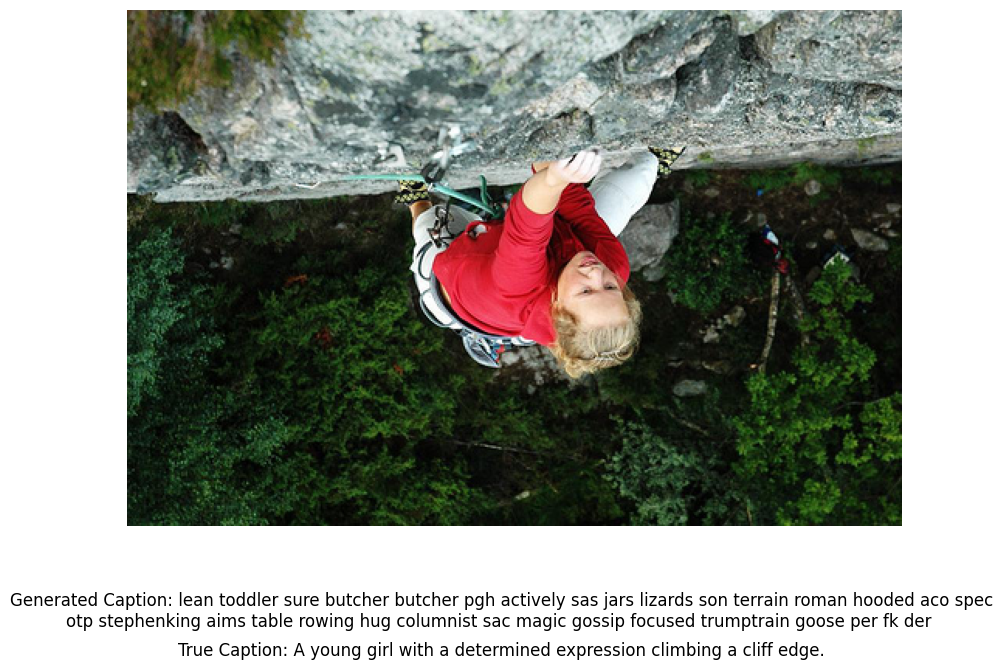

In [19]:
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel
import random
import time
from IPython.display import display, clear_output

def generate_and_visualize(test_dataset, decoder, clip_model, clip_processor, tokenizer, device):
    """
    Generate caption for a random image and visualize the results.
    
    Args:
        test_dataset: Dataset containing images and captions
        decoder: Trained decoder model
        clip_model: CLIP model
        clip_processor: CLIP processor
        tokenizer: CLIP tokenizer
        device: torch device
    """
    # Get a random image from the test set
    idx = random.randint(0, len(test_dataset) - 1)
    sample = test_dataset[idx]
    image = sample['image']
    true_caption = sample['caption'][0]  # Get the first caption
    
    # Process image through CLIP
    inputs = clip_processor(images=image, return_tensors="pt").to(device)

    text_projection_layer = torch.nn.Linear(512, 256).to(device)
    
    with torch.no_grad():
        # Get image embeddings from CLIP
        patch_embeddings = clip_model.vision_model(**inputs).last_hidden_state[:, 1:, :].squeeze(0)
        
        # Project image features to the embedding dimension
        image_projection_layer = torch.nn.Linear(patch_embeddings.shape[-1], 256).to(device)
        img_features = image_projection_layer(patch_embeddings)
        img_features = img_features.unsqueeze(0)

        
    
    # Initialize with start token
    start_token = tokenizer.encode("<|startoftext|>")[0]
    end_token = tokenizer.encode("<|endoftext|>")[0]
    
    generated_tokens = [start_token]
    generated_caption = ""
    
    # Generate tokens one by one
    for _ in range(32):  # max length of 32 tokens
        # Convert generated tokens to tensor
        input_ids = torch.tensor([generated_tokens]).to(device)
        
        # Get text embeddings
        with torch.no_grad():
            text_embeddings = clip_model.text_model.embeddings(input_ids).squeeze(0)
            text_embeddings = text_embeddings.unsqueeze(0)
            text_inputs = text_projection_layer(text_embeddings)
        
        # Get logits from decoder
        logits = decoder(text_inputs, img_features)

        # Get probabilities
        probabilities = torch.softmax(logits[0, -1], dim=-1)

        
        next_token = torch.multinomial(probabilities, 1).item()

        # Get next token (greedy decoding)
        #next_token = logits[0, -1].argmax(dim=-1).item()
        generated_tokens.append(next_token)
        
        # Decode the current token and add to caption
        current_word = tokenizer.decode([next_token], skip_special_tokens=True)
        generated_caption += current_word + " "
        
        # Print the current state of the caption
        print(f"\rGenerating caption: {generated_caption}", end="", flush=True)
        time.sleep(0.1)  # Add a small delay for visualization
        
        # Stop if we generate the end token
        if next_token == end_token:
            break
    
    print()  # New line after caption generation
    
    # Display the image and captions
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.figtext(0.5, 0.01, f"True Caption: {true_caption}", 
                ha='center', fontsize=12, wrap=True)
    plt.figtext(0.5, 0.05, f"\nGenerated Caption: {generated_caption}", 
                ha='center', fontsize=12, wrap=True)
    plt.show()

# Example usage:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models and processors
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Parameters for decoder
embedding_dim = 256
num_heads = 8
mlp_dimension = 2048
num_layers = 4
input_sequence_length = 32
vocab_size = 49408

decoder = Decoder(embedding_dim=embedding_dim, num_heads=num_heads, 
                  mlp_dimension=mlp_dimension, num_layers=num_layers, 
                  vocab_size=vocab_size).to(device)

# Load trained weights if you have them
decoder.load_state_dict(torch.load("decoder_08052002.pt"))
decoder.eval()

# Generate and visualize caption
generate_and_visualize(test, decoder, clip_model, clip_processor, tokenizer, device)


### DUMP

In [ ]:
# captions produces a list of captions
#captions = [caption for caption_list[0] for caption_list in test['caption']]  

captions = []
for caption_list in test['caption']:
    for caption in caption_list[0]:
        captions.append(caption)



The change from total_loss and num_batches to epoch_losses = [] offers several advantages:
More Accurate Average:
With total_loss and num_batches, you're calculating a running average that might be affected by the order of batches
With epoch_losses, you store all individual losses and calculate the true average at the end, which is more accurate
More Information:
By storing all losses in a list, you can:
Calculate the median loss
Find the minimum and maximum losses
Plot the loss distribution
Detect outliers or unusual patterns
Calculate standard deviation
Debugging and Analysis:
If you notice something unusual in the average loss, you can look at the individual losses to understand what's happening
You can track how the loss changes throughout the epoch